In [2]:
import numpy as np
np.set_printoptions(suppress=True)
import pandas as pd
from pandas import Series
pd.set_option('display.float_format', lambda x: '%.3f' % x)
import datetime
from scipy.stats import ttest_ind
from scipy.stats import spearmanr

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA

from sklearn.metrics import mean_squared_error, f1_score, accuracy_score, roc_curve, roc_auc_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc

from sklearn.model_selection import train_test_split 
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier

from sklearn.utils.class_weight import compute_class_weight

from matplotlib import pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [4]:
one_hot=OneHotEncoder()
l_enc=LabelEncoder()
st_sc=StandardScaler()
r_sc=RobustScaler()

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
url1='/content/drive/MyDrive/Colab Notebooks/data/trainp4.csv'
url2='/content/drive/MyDrive/Colab Notebooks/data/testp4.csv'

In [7]:
df_train = pd.read_csv(url1, encoding = 'ISO-8859-1', low_memory = False)  #"./train.csv"
print('Traning dataset',df_train.shape)
df_test = pd.read_csv(url2, encoding = 'ISO-8859-1', low_memory = False)  #"./train.csv"
print('Testing dataset',df_test.shape)

Traning dataset (73799, 19)
Testing dataset (36349, 18)


In [8]:
print(df_test.shape[0]/(df_train.shape[0]+df_test.shape[0])) # Какую долю потом выделять как тестовую

0.3300014525910593


In [9]:
df=pd.concat([df_train,df_test], axis=0,ignore_index=True) #Объединяем, чтобы все признаки прошли одинаковую обработку
df.shape

(110148, 19)

# **PREPROCESSING & EDA**

client_id - идентификатор клиента

education - уровень образования

sex - пол заемщика

age - возраст заемщика

car - флаг наличия автомобиля

car_type - флаг автомобиля иномарки

decline_app_cnt - количество отказанных прошлых заявок

good_work - флаг наличия “хорошей” работы

bki_request_cnt - количество запросов в БКИ

home_address - категоризатор домашнего адреса

work_address - категоризатор рабочего адреса

income - доход заемщика

foreign_passport - наличие загранпаспорта

sna - связь заемщика с клиентами банка

first_time - давность наличия информации о заемщике

score_bki - скоринговый балл по данным из БКИ

region_rating - рейтинг региона

app_date - дата подачи заявки

default - флаг дефолта по кредиту

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

In [11]:
weights=df['default'].value_counts()
display(weights) #Датасет несбалансированный. Как-нибудь потом это учтём.
sum=weights.sum()

0.000    64427
1.000     9372
Name: default, dtype: int64

In [12]:
columns=df.columns
print(columns)

Index(['client_id', 'app_date', 'education', 'sex', 'age', 'car', 'car_type',
       'decline_app_cnt', 'good_work', 'score_bki', 'bki_request_cnt',
       'region_rating', 'home_address', 'work_address', 'income', 'sna',
       'first_time', 'foreign_passport', 'default'],
      dtype='object')


In [13]:
#Сгруппируем признаки
binary_columns=['sex','education', 'good_work', 'foreign_passport','car','car_type']
numerical_columns=[ 'age', 'decline_app_cnt','bki_request_cnt', 'score_bki', 'region_rating','income']
categorical_columns=['home_address','work_address','sna']
date_columns= ['app_date']
uncategorized= ['first_time']

print('НАЧАЛЬНОЕ ЧИСЛО ПРИЗНАКОВ',len(binary_columns)+len(numerical_columns)+len(date_columns)+len(uncategorized)+len(categorical_columns))

НАЧАЛЬНОЕ ЧИСЛО ПРИЗНАКОВ 17


*Пропущенные Значения*

In [14]:
df.isnull().sum() # Нулевые значения целевой переменной для тестовой части сета будем игнорировать

client_id               0
app_date                0
education             478
sex                     0
age                     0
car                     0
car_type                0
decline_app_cnt         0
good_work               0
score_bki               0
bki_request_cnt         0
region_rating           0
home_address            0
work_address            0
income                  0
sna                     0
first_time              0
foreign_passport        0
default             36349
dtype: int64

In [15]:
# Хотя пропущенных значений education не много, я не буду их удалять, в таком аккуратном датасете это может тоже что-то значить, превращу его в дополнительное значение признака

df['education']=df['education'].apply(lambda x:'NO_INFO' if str(x)=='nan' else x) 

*LABEL ENCODING*

In [16]:
columns_for_lable_encoding=['sex','car', 'car_type','foreign_passport','education']    
classes_from_Label_Encoding={}  #Сохраним исходные наименования признаков, на всякий случай

for column in columns_for_lable_encoding:
  print(column)
  df[column] = l_enc.fit_transform(df[column])
  classes_from_Label_Encoding.update({column : dict(enumerate(l_enc.classes_)) })  # Пригодятся

df[columns_for_lable_encoding].head()


sex
car
car_type
foreign_passport
education


,sex,car,car_type,foreign_passport,education
0,1,1,1,0,4
1,0,0,0,0,4
2,1,1,0,1,4
3,0,0,0,0,4
4,1,0,0,1,1


In [17]:
print(classes_from_Label_Encoding)

{'sex': {0: 'F', 1: 'M'}, 'car': {0: 'N', 1: 'Y'}, 'car_type': {0: 'N', 1: 'Y'}, 'foreign_passport': {0: 'N', 1: 'Y'}, 'education': {0: 'ACD', 1: 'GRD', 2: 'NO_INFO', 3: 'PGR', 4: 'SCH', 5: 'UGR'}}


***APPLICATION*** ***DATE*** 

In [18]:
df_date=df['app_date'].copy()
df_date=pd.to_datetime(df_date, format='%d%b%Y')
df_date=pd.DataFrame(df_date,columns=['app_date'])

In [19]:
df_date['Month']=df_date['app_date'].apply(lambda x:x.month) # Попробуем достать месяц

In [20]:
df_date['Month'].value_counts() # Данные за неполный год, это направление развивать нет смысла

3    31597
2    27097
4    26266
1    25188
Name: Month, dtype: int64

In [21]:
df_date['dow']=df_date['app_date'].apply(lambda x:x.weekday()) # Попробуем достать день недели

In [22]:
df_date['dow'].value_counts() # Как ни странно, на выходных тоже подают заявки на кредит. понедельник - 0, воскресенье - 6

1    18180
0    17858
2    17581
3    17421
4    16749
5    12202
6    10157
Name: dow, dtype: int64

In [23]:
# Попробуем выделить это как бинарный признак, то есть заявка подана в будни = 1, заявка подана на выходных = 0

df_date['weekday']=df_date['dow'].apply(lambda x:1 if x<5 else 0)

In [24]:
df_date['weekday'].value_counts() #

1    87789
0    22359
Name: weekday, dtype: int64

In [25]:
df=df.join(df_date['weekday'])         
df=df.drop(labels=['app_date'],axis=1) 

print(df.shape)

(110148, 19)


**Исследование на значимость дискретных признаков:**


In [26]:
discret_col=['education', 'sex', 'car', 'car_type', 'good_work','home_address', 'work_address', 'sna','first_time', 'foreign_passport','weekday']
df_discrete=df.iloc[0:73799,:].copy()
print(df_discrete.shape)

(73799, 19)


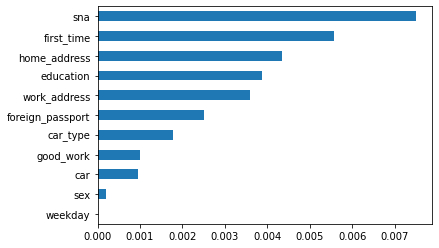

In [27]:
importance_discrete = Series (mutual_info_classif(df_discrete[discret_col],df_discrete['default'],discrete_features =True),index=discret_col)
importance_discrete.sort_values(inplace = True)
importance_discrete.plot(kind = 'barh')

Созданный нами новый признак WEEKDAY вообще никак не влияет на целевую переменную! Включать в модель не будем

In [28]:
# Дополнительно протестируем, правда ли, что пол не влияет на нашу целевую переменную.
df_discrete['sex'].value_counts()

0    41562
1    32237
Name: sex, dtype: int64

In [29]:
#Сделаем выборку мужчин и женщин из сета. Нулева гипотеза: пол не влияет на дефолт по кредиту
sample_size=30000
sample1= np.random.choice(df_discrete[(df_discrete['sex']==0)]['default'],sample_size) 
sample2= np.random.choice(df_discrete[(df_discrete['sex']==1)]['default'],sample_size) 
alpha=0.05

def compare_two_populations(sample1, sample2,alpha,sample_size):
    stat, p = ttest_ind(sample1,sample2)
   
    if p> alpha:
        print('популяции одинаковые, нулевую гипотезу опровергнуть не удалось')
    else:
        print('популяции отличаются, нулевую гипотезу опровергнуть удалось')
    return 

compare_two_populations(sample1, sample2,alpha,sample_size)

популяции отличаются, нулевую гипотезу опровергнуть удалось


ВЫВОД: мы всё-таки включим этот признак в модель

**Исследования на мультиколлинеарность**

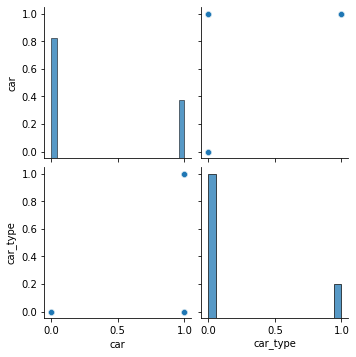

In [30]:
#Признаки наличия машины и типа машины
df_car=df[['car','car_type']]
sns.pairplot(df_car)

Мне кажется, или просматривается линейная зависимость?


In [31]:
# Нам подскажет Spearman's rank correlation coefficient

correlation, pvalue = spearmanr(df_car['car'],df_car['car_type'])
print('Spearmans rank correlation coefficient', correlation )


Spearmans rank correlation coefficient 0.6987602430716485


Подтверждено.

Так как это категориальные переменные, я не решусь как-либо комбинировать их. Я просто выброшу переменную наличия машины, и оставлю переменную типа машины, потому что она сильнее влияет на целевую переменную.

*DUMMIES*

In [32]:
#FIRST TIME "Это может быть разного рода информация. ... Точной расшифровки у нас нет"
enc_df=pd.get_dummies(df['first_time'],prefix='FT_')
df=df.join(enc_df)
print(df.shape)

(110148, 23)


In [33]:
#EDUCATION        
enc_df=pd.get_dummies(df['education'],prefix='EDU_')
df=df.join(enc_df)    
print(df.shape)

(110148, 29)


Для справки:
Я пробовала по-другому обработать  этот признак

EDUCATION

GRD - graduate, 

SCH - school. 

PGR - post-graduate, 

UGR - undergraduate, 

ACD - associate college degree, 

это всё уровни образования. 

Я оставила только один признак, есть высшее или нет - сгруппировала  NO INFO, SCH , ACD И UGR в как 0 и всё остальное - как 1.

df['education']=df['education'].apply(lambda x:1 if str(x)=='GRD' or str(x)=='PGR' else 0) 

Но это не дало улучшения результата обучения модели.

In [34]:
#HOME ADDRESS
enc_df=pd.get_dummies(df['home_address'],prefix='HAdd_')
df=df.join(enc_df)
print(df.shape)

(110148, 32)


In [35]:
#WORK ADDRESS
enc_df=pd.get_dummies(df['work_address'],prefix='WAdd_')
df=df.join(enc_df)  
print(df.shape)

(110148, 35)


ДРУГИЕ ПРЕОБРАЗОВАНИЯ

In [36]:
#SNA "Это уровень связи. Например муж который является клиентом банка это очень близкая связь. Ваша сестра менее близкая. Друг или коллега ещё менее близкая"
# При прогоне модели этот признак, разложенный как dummies, получил нулевые коэффициенты для связей уровня 3 и 4. Поэтому сделаем следующее преобразование:

df['sna']=df['sna'].apply(lambda x:1 if x==1 or x==2 else 0) # Распределим отношения на две группы: близкие - 1, дальние - 0

In [37]:
df=df.drop(labels=['first_time','work_address','home_address','education','car','weekday'],axis=1) # минус 6 признаков
df.shape

(110148, 29)

## ***numerical columns***

In [38]:
print(numerical_columns)

['age', 'decline_app_cnt', 'bki_request_cnt', 'score_bki', 'region_rating', 'income']



 age
DEFALT


count   9372.000
mean      38.525
std       11.496
min       21.000
25%       29.000
50%       36.000
75%       47.000
max       72.000
Name: age, dtype: float64

NOT DEFAULT


count   100776.000
mean        39.317
std         11.518
min         21.000
25%         30.000
50%         37.000
75%         48.000
max         72.000
Name: age, dtype: float64


 decline_app_cnt
DEFALT


count   9372.000
mean       0.515
std        1.137
min        0.000
25%        0.000
50%        0.000
75%        1.000
max       22.000
Name: decline_app_cnt, dtype: float64

NOT DEFAULT


count   100776.000
mean         0.251
std          0.756
min          0.000
25%          0.000
50%          0.000
75%          0.000
max         33.000
Name: decline_app_cnt, dtype: float64


 bki_request_cnt
DEFALT


count   9372.000
mean       2.462
std        2.727
min        0.000
25%        1.000
50%        2.000
75%        3.000
max       46.000
Name: bki_request_cnt, dtype: float64

NOT DEFAULT


count   100776.000
mean         1.962
std          2.215
min          0.000
25%          0.000
50%          1.000
75%          3.000
max         53.000
Name: bki_request_cnt, dtype: float64


 score_bki
DEFALT


count   9372.000
mean      -1.676
std        0.495
min       -3.456
25%       -2.016
50%       -1.684
75%       -1.338
max        0.200
Name: score_bki, dtype: float64

NOT DEFAULT


count   100776.000
mean        -1.926
std          0.494
min         -3.625
25%         -2.276
50%         -1.944
75%         -1.594
max          0.200
Name: score_bki, dtype: float64


 region_rating
DEFALT


count   9372.000
mean      53.678
std       11.918
min       20.000
25%       50.000
50%       50.000
75%       60.000
max       80.000
Name: region_rating, dtype: float64

NOT DEFAULT


count   100776.000
mean        57.037
std         13.131
min         20.000
25%         50.000
50%         50.000
75%         60.000
max         80.000
Name: region_rating, dtype: float64


 income
DEFALT


count     9372.000
mean     36288.113
std      40026.390
min       3700.000
25%      20000.000
50%      28000.000
75%      40000.000
max     830000.000
Name: income, dtype: float64

NOT DEFAULT


count    100776.000
mean      41452.022
std       45842.904
min        1000.000
25%       20000.000
50%       30000.000
75%       50000.000
max     1000000.000
Name: income, dtype: float64

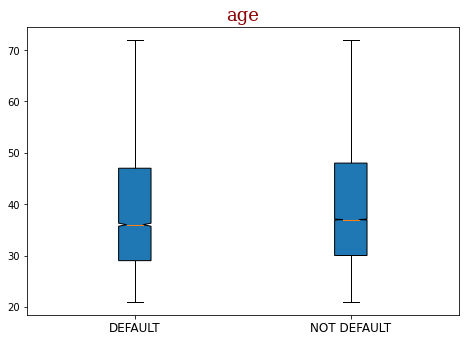

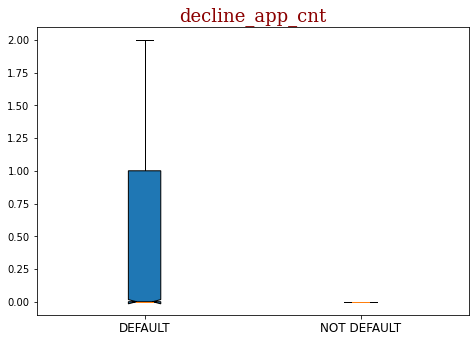

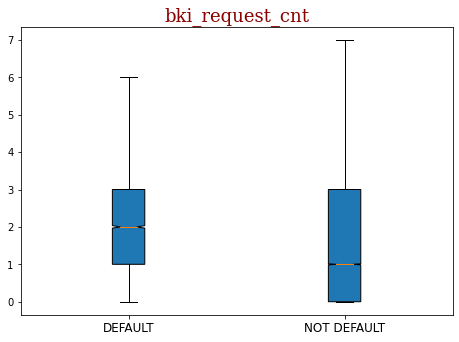

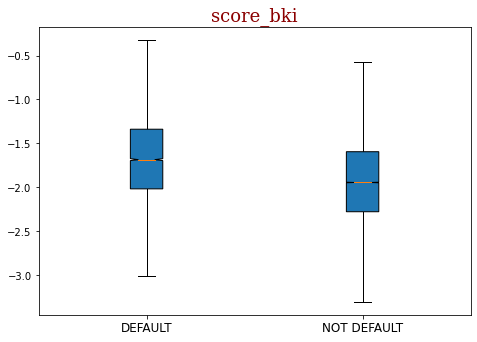

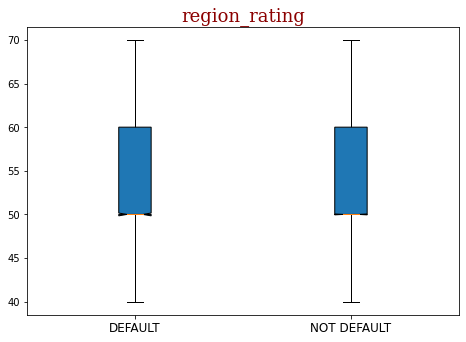

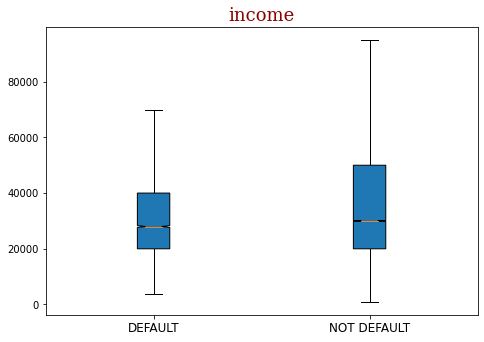

In [39]:
df_num_target=df[['age', 'decline_app_cnt', 'bki_request_cnt', 'score_bki', 'region_rating', 'income','default']].copy()


for i in numerical_columns:
  print('\n',i)
  print('DEFALT')
  display(df_num_target[df_num_target['default']==1][i].describe())
  print('NOT DEFAULT')
  display(df_num_target[df_num_target['default']!=1][i].describe())

  figure_numerical=plt.figure()
  numerical_axes=figure_numerical.add_axes([0,0,1,1])

  plot_1=df_num_target[df_num_target['default']==1][i]
  plot_2=df_num_target[df_num_target['default']!=1][i]

  numerical_axes.boxplot([plot_1,plot_2],  notch=True,  patch_artist=True,showfliers=False)  #showfliers=True  чтобы посмотреть на outliers

  font_t = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 18}

  numerical_axes.set_title(i ,fontdict=font_t)
  numerical_axes.set_xticklabels(['DEFAULT','NOT DEFAULT'], fontsize=12)
           
  plt.show

In [40]:
# Все числовые признаки кроме age, для обоих подмножеств, и дефолтных, и недефолтных, имеют много outliers (чтобы это увидеть, в боксплотах надо поменять парамаетр showflier=True ) 
# Поэтому я решила применить ко всем стандартизацию RobustScaler. Age это не повредит, я проверяла.

In [41]:
#SCALING by RobustScaler

num_col=r_sc.fit_transform((df[numerical_columns].values), y=None)
print(num_col.shape)


(110148, 6)


# **ФОРМИРУЕМ МАССИВЫ**

In [94]:
Y = df['default'].values
df_x=df.drop(labels=['client_id', 'age', 'decline_app_cnt', 'bki_request_cnt', 'score_bki', 'region_rating', 'income','default'],axis=1) 
save_feature_names=df_x.columns  #Нам это пригодится позже
X = np.hstack([num_col, df_x.values])

In [95]:
# Добавим  столбец единиц 
X = np.hstack([np.ones(X.shape[0])[:, np.newaxis], X])
print(X.shape)

(110148, 28)


In [96]:
 # Разделим обработанные данные на датасеты с исходными размерами:

X_train_valid, X_test, y_train_valid, y_test = train_test_split(X, Y, test_size=0.3300014525910593, random_state=0, shuffle=False)
print(X_train_valid.shape)
print(X_test.shape)

(73799, 28)
(36349, 28)


In [97]:
# посчитаем веса для нашего несбалансированного датасета
weighting = compute_class_weight('balanced', [0,1], y_train_valid)
print(weighting)

[0.57273348 3.93720657]


In [98]:
# А датасет для обучения будет разбит на два методом StratifiedShuffleSplit, так как он очень несбалансированный по классам:

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.20,random_state=0)
split=sss.split(X_train_valid, y_train_valid)

for train_index, test_index in split: 
    X_train, X_valid = X_train_valid[train_index], X_train_valid[test_index] 
    y_train, y_valid = y_train_valid[train_index], y_train_valid[test_index] 
print(X_train.shape)

(59039, 28)


#**ОБУЧЕНИЕ**

In [135]:
errors={}  # Будем собирать сюда ошибки

In [149]:
#1 LOGISTIC REGRESSION

lr_model = LogisticRegression(random_state=0,class_weight='balanced')      #class_weight='balanced' равно class_weight={0:0.57273348,1: 3.93720657}
lr_model.fit(X_train, y_train)

Y_tr_predict = lr_model.predict(X_train)          # Непосредсвенно классификация на тренировочном сете
Y_tr_pred_prob = lr_model.predict_proba(X_train)  # Предсказанные вероятности для тренировочного сета

print('Accuracy',round(accuracy_score(y_train,Y_tr_predict),2))
print('Precision',round(precision_score(y_train,Y_tr_predict),2))
print('Recall',round(recall_score(y_train,Y_tr_predict),2))
print('Harmonic balance between Precision and Recall',round(f1_score(y_train,Y_tr_predict),2))
print('AREA UNDER CURVE',round(roc_auc_score(y_train, Y_tr_pred_prob[:,1]),2))

Accuracy 0.67
Precision 0.23
Recall 0.67
Harmonic balance between Precision and Recall 0.34
AREA UNDER CURVE 0.73


In [150]:
Y_v_predict = lr_model.predict(X_valid)          # Непосредсвенно классификация на валидационном сете
Y_v_pred_prob = lr_model.predict_proba(X_valid)  # Предсказанные вероятности для валидационного сета

print('Accuracy',round(accuracy_score(y_valid,Y_v_predict),2))
print('Precision',round(precision_score(y_valid,Y_v_predict),2))
print('Recall',round(recall_score(y_valid,Y_v_predict),2))
print('Harmonic balance between Precision and Recall',round(f1_score(y_valid,Y_v_predict),2))
print('AREA UNDER CURVE',round(roc_auc_score(y_valid, Y_v_pred_prob[:,1]),2))
print('CONFUSION MATRIX','\n',confusion_matrix(y_valid, Y_v_predict))
tn, fp, fn, tp = confusion_matrix(y_valid, Y_v_predict).ravel()
print('Ошибки II рода: ',fn)  # дать кредит неблагонадёжному заёмщику
print('Ошибки I рода: ',fp) # Отказ в кредите хорошему заемщику
m_errors={'Ошибки II рода:':fn, 'Ошибки I рода: ':fp}
errors.update({'lr_model':m_errors})

Accuracy 0.66
Precision 0.22
Recall 0.65
Harmonic balance between Precision and Recall 0.33
AREA UNDER CURVE 0.72
CONFUSION MATRIX 
 [[8510 4376]
 [ 650 1224]]
Ошибки II рода:  650
Ошибки I рода:  4376


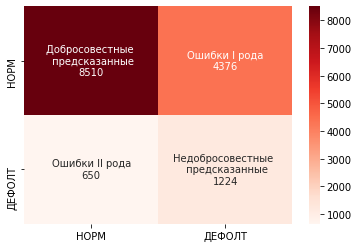

In [138]:
labels = np.asarray(['Добросовестные \n предсказанные'+'\n'+str(tn),
                     'Ошибки I рода'+'\n'+str(fp),
                     'Ошибки II рода'+'\n'+str(fn),  
                     'Недобросовестные \n предсказанные'+'\n'+str(tp)]).reshape(2,2)
categories = ['НОРМ', 'ДЕФОЛТ']
sns.heatmap(confusion_matrix(y_valid, Y_v_predict), annot=labels, fmt='', cmap='Reds', yticklabels= categories, xticklabels= categories)

Применение балансировки по классам  улучшает F1 score, но мне всё равно не нравится количество ошибок второго рода! AUC при этом не меняется



In [139]:
#2 RANDOM FORESTS

rf_model = RandomForestClassifier(class_weight='balanced',random_state=0)
rf_model.fit(X_train, y_train)

Y_tr_predict = rf_model.predict(X_train)          # Непосредсвенно классификация на тренировочном сете
Y_tr_pred_prob = rf_model.predict_proba(X_train)  # Предсказанные вероятности для тренировочного сета

print('Accuracy',round(accuracy_score(y_train,Y_tr_predict),2))
print('Precision',round(precision_score(y_train,Y_tr_predict),2))
print('Recall',round(recall_score(y_train,Y_tr_predict),2))
print('Harmonic balance between Precision and Recall',round(f1_score(y_train,Y_tr_predict),2))
print('AREA UNDER CURVE',round(roc_auc_score(y_train, Y_tr_pred_prob[:,1]),2))

Accuracy 1.0
Precision 1.0
Recall 1.0
Harmonic balance between Precision and Recall 1.0
AREA UNDER CURVE 1.0


In [140]:
Y_v_predict = rf_model.predict(X_valid)          # Непосредсвенно классификация на валидационном сете
Y_v_pred_prob = rf_model.predict_proba(X_valid)  # Предсказанные вероятности для валидационного сета

print('Accuracy',round(accuracy_score(y_valid,Y_v_predict),2))
print('Precision',round(precision_score(y_valid,Y_v_predict),2))
print('Recall',round(recall_score(y_valid,Y_v_predict),2))
print('Harmonic balance between Precision and Recall',round(f1_score(y_valid,Y_v_predict),2))
print('AREA UNDER CURVE',round(roc_auc_score(y_valid, Y_v_pred_prob[:,1]),2))
print('CONFUSION MATRIX','\n',confusion_matrix(y_valid, Y_v_predict))
tn, fp, fn, tp = confusion_matrix(y_valid, Y_v_predict).ravel()
print('Ошибки II рода: ',fn)  # дать кредит неблагонадёжному заёмщику
print('Ошибки I рода: ',fp) # Отказ в кредите хорошему заемщику
m_errors={'Ошибки II рода:':fn, 'Ошибки I рода: ':fp}
errors.update({'rf_model':m_errors})

Accuracy 0.87
Precision 0.42
Recall 0.03
Harmonic balance between Precision and Recall 0.05
AREA UNDER CURVE 0.69
CONFUSION MATRIX 
 [[12812    74]
 [ 1820    54]]
Ошибки II рода:  1820
Ошибки I рода:  74


In [141]:
#3 ADABOOST CLASSIFIER      

ada_model=AdaBoostClassifier(random_state=0)  # НЕ ПОЗВОЛЯЕТ ЗАДАВАТЬ БАЛАНСИРОВКУ ПО КЛАССАМ?
ada_model.fit(X_train, y_train)

Y_tr_predict = ada_model.predict(X_train)          # Непосредсвенно классификация на тренировочном сете
Y_tr_pred_prob = ada_model.predict_proba(X_train)  # Предсказанные вероятности для тренировочного сета

print('Accuracy',round(accuracy_score(y_train,Y_tr_predict),2))
print('Precision',round(precision_score(y_train,Y_tr_predict),2))
print('Recall',round(recall_score(y_train,Y_tr_predict),2))
print('Harmonic balance between Precision and Recall',round(f1_score(y_train,Y_tr_predict),2))
print('AREA UNDER CURVE',round(roc_auc_score(y_train, Y_tr_pred_prob[:,1]),2))


Accuracy 0.87
Precision 0.45
Recall 0.03
Harmonic balance between Precision and Recall 0.06
AREA UNDER CURVE 0.74


In [142]:
Y_v_predict = ada_model.predict(X_valid)          # Непосредсвенно классификация на валидационном сете
Y_v_pred_prob = ada_model.predict_proba(X_valid)  # Предсказанные вероятности для валидационного сета

print('Accuracy',round(accuracy_score(y_valid,Y_v_predict),2))
print('Precision',round(precision_score(y_valid,Y_v_predict),2))
print('Recall',round(recall_score(y_valid,Y_v_predict),2))
print('Harmonic balance between Precision and Recall',round(f1_score(y_valid,Y_v_predict),2))
print('AREA UNDER CURVE',round(roc_auc_score(y_valid, Y_v_pred_prob[:,1]),2))
print('CONFUSION MATRIX','\n',confusion_matrix(y_valid, Y_v_predict))
tn, fp, fn, tp = confusion_matrix(y_valid, Y_v_predict).ravel()
print('Ошибки II рода: ',fn)  # дать кредит неблагонадёжному заёмщику
print('Ошибки I рода: ',fp) # Отказ в кредите хорошему заемщику
m_errors={'Ошибки II рода:':fn, 'Ошибки I рода: ':fp}
errors.update({'ada_model':m_errors})

Accuracy 0.87
Precision 0.5
Recall 0.03
Harmonic balance between Precision and Recall 0.06
AREA UNDER CURVE 0.72
CONFUSION MATRIX 
 [[12823    63]
 [ 1811    63]]
Ошибки II рода:  1811
Ошибки I рода:  63


In [143]:
# KNNClassifier

knn_model=KNeighborsClassifier() # НЕ ПОЗВОЛЯЕТ ЗАДАВАТЬ БАЛАНСИРОВКУ ПО КЛАССАМ?
knn_model.fit(X_train, y_train)

Y_tr_predict = knn_model.predict(X_train)          # Непосредсвенно классификация на тренировочном сете
Y_tr_pred_prob = knn_model.predict_proba(X_train)  # Предсказанные вероятности для тренировочного сета

print('Accuracy',round(accuracy_score(y_train,Y_tr_predict),2))
print('Precision',round(precision_score(y_train,Y_tr_predict),2))
print('Recall',round(recall_score(y_train,Y_tr_predict),2))
print('Harmonic balance between Precision and Recall',round(f1_score(y_train,Y_tr_predict),2))
print('AREA UNDER CURVE',round(roc_auc_score(y_train, Y_tr_pred_prob[:,1]),2))


Accuracy 0.88
Precision 0.65
Recall 0.19
Harmonic balance between Precision and Recall 0.3
AREA UNDER CURVE 0.88


In [144]:
Y_v_predict = knn_model.predict(X_valid)          # Непосредсвенно классификация на валидационном сете
Y_v_pred_prob = knn_model.predict_proba(X_valid)  # Предсказанные вероятности для валидационного сета

print('Accuracy',round(accuracy_score(y_valid,Y_v_predict),2))
print('Precision',round(precision_score(y_valid,Y_v_predict),2))
print('Recall',round(recall_score(y_valid,Y_v_predict),2))
print('Harmonic balance between Precision and Recall',round(f1_score(y_valid,Y_v_predict),2))
print('AREA UNDER CURVE',round(roc_auc_score(y_valid, Y_v_pred_prob[:,1]),2))
print('CONFUSION MATRIX','\n',confusion_matrix(y_valid, Y_v_predict))
tn, fp, fn, tp = confusion_matrix(y_valid, Y_v_predict).ravel()
print('Ошибки II рода: ',fn)  # дать кредит неблагонадёжному заёмщику
print('Ошибки I рода: ',fp) # Отказ в кредите хорошему заемщику
m_errors={'Ошибки II рода:':fn, 'Ошибки I рода: ':fp}
errors.update({'knn_model':m_errors})

Accuracy 0.86
Precision 0.3
Recall 0.08
Harmonic balance between Precision and Recall 0.13
AREA UNDER CURVE 0.61
CONFUSION MATRIX 
 [[12528   358]
 [ 1721   153]]
Ошибки II рода:  1721
Ошибки I рода:  358


**ВЫБОР АЛГОРИТМА ДЛЯ МОДЕЛИ**

Отказ в кредите хорошему заемщику — ошибка первого рода. Риск, с которым сталкивается кредитная организация — дать кредит неблагонадёжному заёмщику, который впоследствии может допустить дефолт, а банк потеряет деньги — ошибка второго рода.


In [145]:
df_errors=pd.DataFrame(errors)
display(df_errors)

,lr_model,rf_model,ada_model,knn_model
Ошибки II рода:,650,1820,1811,1721
Ошибки I рода:,4376,74,63,358


Я предполагаю, что в среднем упущенная выгода по ошибкам первого рода меньше, чем потери банка при ошибках второго рода. 
При условии, что процентные ставки по кредитам невысокие, а суммы, запрашиваемые клиентами достаточно большие, логистическая регрессия представляется наиболее подходящей для целей оценки заёмщиков

Дальнейшие исследования будут проводиться для логистической регрессии и для ADA boost для сравнения

In [151]:
Y_v_predict = lr_model.predict(X_valid)          # Непосредсвенно классификация на валидационном сете
Y_v_pred_prob = lr_model.predict_proba(X_valid)  # Предсказанные вероятности для валидационного сета

predictions=pd.Series(Y_v_pred_prob[:,1])
fpr, tpr, thresholds = roc_curve(y_valid, predictions)

accuracy_ls = []
for thres in thresholds:
    y_pred = np.where(predictions>thres,1,0)
 
    accuracy_ls.append(accuracy_score(y_valid, y_pred, normalize=True))
    
accuracy_ls = pd.concat([pd.Series(thresholds), pd.Series(accuracy_ls)],
                        axis=1)
accuracy_ls.columns = ['thresholds', 'accuracy']
accuracy_ls.sort_values(by='accuracy', ascending=False, inplace=True)
accuracy_ls.head(2)


,thresholds,accuracy
5,0.948,0.873
3,0.967,0.873


In [152]:
display(accuracy_ls[accuracy_ls['accuracy']==accuracy_ls['accuracy'].max()]['thresholds'].min())
display(accuracy_ls[accuracy_ls['accuracy']==accuracy_ls['accuracy'].max()]['thresholds'].max())

0.948289436240409

0.948289436240409

*То есть, 87% дефолтов предсказываются правильно при пороговом значении threshold 0.94?*


(0.0, 1.0)

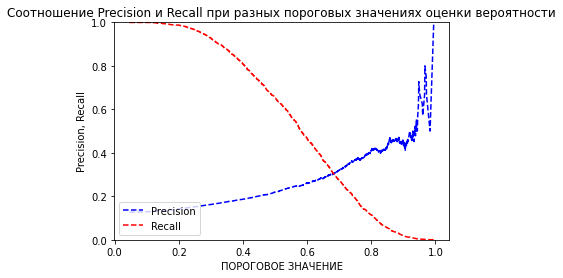

In [153]:
# Precision / Recall Curve
precision, recall, thresholds = precision_recall_curve(y_valid, Y_v_pred_prob[:,1]) 
  
pr_auc = auc(recall, precision)

plt.title("Соотношение Precision и Recall при разных пороговых значениях оценки вероятности")
plt.plot(thresholds, precision[: -1], "b--", label="Precision") # Вероятность, что 1 - вторая колонка предсказанных Y
plt.plot(thresholds, recall[: -1], "r--", label="Recall")
plt.ylabel("Precision, Recall")
plt.xlabel("ПОРОГОВОЕ ЗНАЧЕНИЕ")
plt.legend(loc="lower left")
plt.ylim([0,1])

In [154]:
Y_v_pred_prob = lr_model.predict_proba(X_valid)

fpr, tpr, threshold = roc_curve(y_valid, Y_v_pred_prob[:,1])
roc_auc = roc_auc_score(y_valid, Y_v_pred_prob[:,1])
print(roc_auc)

0.7212951154786305


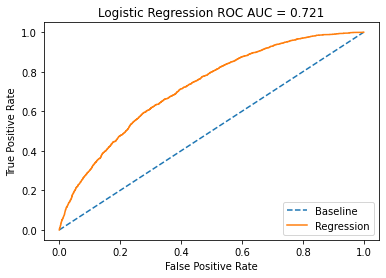

In [155]:
fpr, tpr, threshold = roc_curve(y_valid, Y_v_pred_prob[:,1])
roc_auc = roc_auc_score(y_valid, Y_v_pred_prob[:,1])

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()


# **ГИПЕРПАРАМЕТРЫ**

> Логистическая регрессия



Прохождение нижеследующего квеста дало вот такие результаты:

**Лучшее Penalty: l1**

**Лучший параметр регуляризации: 0.5** 

**Лучший солвер: saga**

**количество итераций: 1000** 


In [172]:
# ограничения для параметра регуляризации (чем мешьше значение C, тем сильнее эффект регуляризации)
c=np.arange(0.05,3,0.1)

# Зададим гиперпараметры:
hyperparameters =  [    
                    {'penalty' : ['l1', 'l2', 'elasticnet'],
                      'C' : c, 
                       'solver' : ['lbfgs','newton-cg','liblinear','sag','saga'],
                       'max_iter' : [100, 1000] }
                    ]

model = LogisticRegression(class_weight='balanced')
model.fit(X_valid, y_valid)

# Создаем сетку поиска с использованием 5-кратной перекрестной проверки
grid_search = GridSearchCV(model, hyperparameters, cv=5, verbose=0) # verbose=10 Интересно смотреть, как кто-то другой работает

best_model = grid_search.fit(X_valid, y_valid)

# Выхлоп:
print('Лучшее Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Лучший параметр регуляризации:', best_model.best_estimator_.get_params()['C'])
print('Лучший солвер:', best_model.best_estimator_.get_params()['solver'])
print('количество итераций:', best_model.best_estimator_.get_params()['max_iter'])

Лучшее Penalty: l1
Лучший параметр регуляризации: 0.05
Лучший солвер: saga
количество итераций: 1000


ГИПЕРПАРАМЕТРЫ
> ADABoost



Результат
Лучшие параметры  {'learning_rate': 0.001, 'n_estimators': 500}
Точность предсказаний 0.8729993149181873

In [ ]:
# Зададим гиперпараметры:

crossvalidation=KFold(n_splits=10,shuffle=True,random_state=1)

ada = AdaBoostClassifier(random_state=0) ##base estimator is DecisionTreeClassifier, max_depth=1

search_grid = {'n_estimators':[500,1000,2000], # The maximum number of estimators at which boosting is terminated. In case of perfect fit, the learning procedure is stopped early.
               'learning_rate':[.001,0.01,.1]} # Learning rate shrinks the contribution of each classifier by learning_rate. There is a trade-off between learning_rate and n_estimators

search=GridSearchCV(estimator=ada,
                    param_grid=search_grid,
                    n_jobs=1,
                    scoring='accuracy',
                    cv=crossvalidation)
search.fit(X_train, y_train)

# Выхлоп:
print('Лучшие параметры ',search.best_params_)
print('Точность предсказаний',search.best_score_)


Лучшие параметры  {'learning_rate': 0.001, 'n_estimators': 500}
Точность предсказаний 0.8729993149181873


Точность не отличается от того, что у нас было

**LogiscticClassification**

**ПОПРОБУЕМ ВПРЯЧЬ РЕЗУЛЬТАТЫ ПОИСКА ПО ГИПЕРПАРАМЕТРАМ
 И ПОСМОТРИМ НА РЕЗУЛЬТАТ**

In [173]:
#1 LOGISTIC REGRESSION

lr_model = LogisticRegression(solver='saga', penalty='l1', C=0.5, random_state=0,class_weight='balanced',max_iter=1000)      # макс кол-во итераций 100 по умолчанию
lr_model.fit(X_train, y_train)

Y_tr_predict = lr_model.predict(X_train)          # Непосредсвенно классификация на тренировочном сете
Y_tr_pred_prob = lr_model.predict_proba(X_train)  # Предсказанные вероятности для тренировочного сета

print('Accuracy',round(accuracy_score(y_train,Y_tr_predict),2))
print('Precision',round(precision_score(y_train,Y_tr_predict),2))
print('Recall',round(recall_score(y_train,Y_tr_predict),2))
print('Harmonic balance between Precision and Recall',round(f1_score(y_train,Y_tr_predict),2))
print('AREA UNDER CURVE',round(roc_auc_score(y_train, Y_tr_pred_prob[:,1]),2))

Accuracy 0.67
Precision 0.23
Recall 0.67
Harmonic balance between Precision and Recall 0.34
AREA UNDER CURVE 0.73


In [174]:
Y_v_predict = lr_model.predict(X_valid)          # Непосредсвенно классификация на валидационном сете
Y_v_pred_prob = lr_model.predict_proba(X_valid)  # Предсказанные вероятности для валидационного сета

print('Accuracy',round(accuracy_score(y_valid,Y_v_predict),2))
print('Precision',round(precision_score(y_valid,Y_v_predict),2))
print('Recall',round(recall_score(y_valid,Y_v_predict),2))
print('Harmonic balance between Precision and Recall',round(f1_score(y_valid,Y_v_predict),2))
print('AREA UNDER CURVE',round(roc_auc_score(y_valid, Y_v_pred_prob[:,1]),2))
print('CONFUSION MATRIX','\n',confusion_matrix(y_valid, Y_v_predict))
tn, fp, fn, tp = confusion_matrix(y_valid, Y_v_predict).ravel()
print('Ошибки II рода: ',fn)  # дать кредит неблагонадёжному заёмщику
print('Ошибки I рода: ',fp) # Отказ в кредите хорошему заемщику

Accuracy 0.66
Precision 0.22
Recall 0.65
Harmonic balance between Precision and Recall 0.33
AREA UNDER CURVE 0.72
CONFUSION MATRIX 
 [[8509 4377]
 [ 650 1224]]
Ошибки II рода:  650
Ошибки I рода:  4377


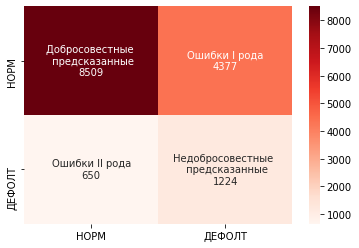

In [175]:
labels = np.asarray(['Добросовестные \n предсказанные'+'\n'+str(tn),
                     'Ошибки I рода'+'\n'+str(fp),
                     'Ошибки II рода'+'\n'+str(fn),  
                     'Недобросовестные \n предсказанные'+'\n'+str(tp)]).reshape(2,2)
categories = ['НОРМ', 'ДЕФОЛТ']
sns.heatmap(confusion_matrix(y_valid, Y_v_predict), annot=labels, fmt='', cmap='Reds', yticklabels= categories, xticklabels= categories)

Показатели не поменялись


________________________________________________________________________________

**ADA Boost**

**ПОПРОБУЕМ ВПРЯЧЬ РЕЗУЛЬТАТЫ ПОИСКА ПО ГИПЕРПАРАМЕТРАМ И ПОСМОТРИМ НА РЕЗУЛЬТАТ**

In [176]:
# ADA BOOST

ada_model = AdaBoostClassifier(n_estimators=500,learning_rate=0.01, random_state=0)     
ada_model.fit(X_train, y_train)

Y_tr_predict = ada_model.predict(X_train)          # Непосредсвенно классификация на тренировочном сете
Y_tr_pred_prob = ada_model.predict_proba(X_train)  # Предсказанные вероятности для тренировочного сета

print('Accuracy',round(accuracy_score(y_train,Y_tr_predict),2))
print('Precision',round(precision_score(y_train,Y_tr_predict),2))
print('Recall',round(recall_score(y_train,Y_tr_predict),2))
print('Harmonic balance between Precision and Recall',round(f1_score(y_train,Y_tr_predict),2))
print('AREA UNDER CURVE',round(roc_auc_score(y_train, Y_tr_pred_prob[:,1]),2))

Accuracy 0.87
Precision 0.0
Recall 0.0
Harmonic balance between Precision and Recall 0.0
AREA UNDER CURVE 0.72


In [177]:
Y_v_predict = ada_model.predict(X_valid)          # Непосредсвенно классификация на валидационном сете
Y_v_pred_prob = ada_model.predict_proba(X_valid)  # Предсказанные вероятности для валидационного сета

print('Accuracy',round(accuracy_score(y_valid,Y_v_predict),4))
print('Precision',round(precision_score(y_valid,Y_v_predict),4))
print('Recall',round(recall_score(y_valid,Y_v_predict),4))
print('Harmonic balance between Precision and Recall',round(f1_score(y_valid,Y_v_predict),4))
print('AREA UNDER CURVE',round(roc_auc_score(y_valid, Y_v_pred_prob[:,1]),4))
print('CONFUSION MATRIX','\n',confusion_matrix(y_valid, Y_v_predict))
tn, fp, fn, tp = confusion_matrix(y_valid, Y_v_predict).ravel()
print('Ошибки II рода: ',fn)  # дать кредит неблагонадёжному заёмщику
print('Ошибки I рода: ',fp) # Отказ в кредите хорошему заемщику


Accuracy 0.873
Precision 0.0
Recall 0.0
Harmonic balance between Precision and Recall 0.0
AREA UNDER CURVE 0.7084
CONFUSION MATRIX 
 [[12886     0]
 [ 1874     0]]
Ошибки II рода:  1874
Ошибки I рода:  0


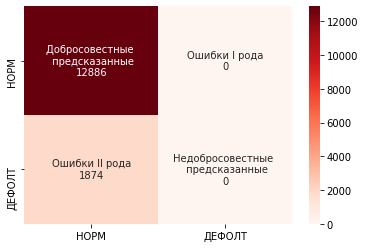

In [178]:
labels = np.asarray(['Добросовестные \n предсказанные'+'\n'+str(tn),
                     'Ошибки I рода'+'\n'+str(fp),
                     'Ошибки II рода'+'\n'+str(fn),  
                     'Недобросовестные \n предсказанные'+'\n'+str(tp)]).reshape(2,2)
categories = ['НОРМ', 'ДЕФОЛТ']
sns.heatmap(confusion_matrix(y_valid, Y_v_predict), annot=labels, fmt='', cmap='Reds', yticklabels= categories, xticklabels= categories)

Модель не выявила дефолтников вообще! Хотя и свела ошибки I рода к нулю!

In [89]:
cm = confusion_matrix(y_valid, Y_v_predict) #Это я перепроверяю, что я правильно обозвала все метрики
cm_dict={'tn': cm[0, 0], 'fp': cm[0, 1],'fn': cm[1, 0], 'tp': cm[1, 1]}
print(cm_dict)

{'tn': 12886, 'fp': 0, 'fn': 1874, 'tp': 0}


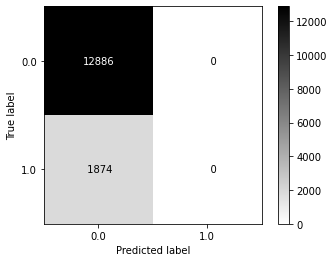

In [180]:
plot_confusion_matrix(ada_model, X_valid ,y_valid, values_format='5g',cmap='binary') # ещё одна перепроверка

________________________________________________________________________________


**Интересно посмотреть, какие коэффициенты модель присвоила признакам  в логистической регрессии**

In [162]:
feature_weights=pd.DataFrame(lr_model.coef_)
weights_columns=[]
for col_name in numerical_columns:
  weights_columns.append(col_name)
for col_name in save_feature_names:
  weights_columns.append(col_name)
weights_columns.append('regularization')
print(len(weights_columns))

28


In [163]:
feature_weights.columns=weights_columns
display(feature_weights.transpose())

,0
age,0.000
decline_app_cnt,-0.078
bki_request_cnt,0.159
score_bki,0.228
region_rating,0.703
income,-0.274
sex,-0.004
car_type,0.299
good_work,-0.295
sna,-0.229


In [ ]:
print(classes_from_Label_Encoding)

{'sex': {0: 'F', 1: 'M'}, 'car': {0: 'N', 1: 'Y'}, 'car_type': {0: 'N', 1: 'Y'}, 'foreign_passport': {0: 'N', 1: 'Y'}, 'education': {0: 'ACD', 1: 'GRD', 2: 'NO_INFO', 3: 'PGR', 4: 'SCH', 5: 'UGR'}}


# **Боремся с несбаласированностью по-другому**

***Попробуем RANDOM SAMPLING***

In [164]:
# Отберём одинаковое количество дефолтных и не дефолтных кейсов:

first=df.iloc[:73799]
second=first.drop(['client_id', 'age', 'decline_app_cnt', 'bki_request_cnt', 'score_bki', 'region_rating', 'income'], axis=1)
df_for_RS=pd.concat([second,pd.DataFrame(num_col)],axis=1)

columns_rs=df_for_RS.columns
display(df_for_RS['default'].value_counts())

X0= df_for_RS[(df_for_RS['default']==0)].sample(9372,random_state=2).copy()
print('X0',X0.shape)
X1=df_for_RS[(df_for_RS['default']==1)]

X_random=pd.concat([X0,X1],axis=0)
Y_random=X_random['default']
X_random=X_random.drop(['default'],axis=1)

# Добавим  столбец единиц 
X_random = np.hstack([np.ones(X_random.shape[0])[:, np.newaxis], X_random])
print('X_random',X_random.shape)

0.000    64427
1.000     9372
Name: default, dtype: int64

X0 (9372, 28)
X_random (18744, 28)


In [165]:
 # Разделим:

X_rand_train, X_rand_valid, y_rand_train, y_rand_valid = train_test_split(X_random, Y_random, test_size=0.3, random_state=0, shuffle=True)
print(X_rand_train.shape)
print(X_rand_valid.shape)

(13120, 28)
(5624, 28)


In [166]:
#Обучим

#1 LOGISTIC REGRESSION

lr_model = LogisticRegression(random_state=0, solver='liblinear', penalty='l1', C=0.5)     
lr_model.fit(X_rand_train, y_rand_train)

Y_tr_predict = lr_model.predict(X_rand_train)          # Непосредсвенно классификация на тренировочном сете
Y_tr_pred_prob = lr_model.predict_proba(X_rand_train)  # Предсказанные вероятности для тренировочного сета

print('Accuracy',round(accuracy_score(y_rand_train,Y_tr_predict),2))
print('Precision',round(precision_score(y_rand_train,Y_tr_predict),2))
print('Recall',round(recall_score(y_rand_train,Y_tr_predict),2))
print('Harmonic balance between Precision and Recall',round(f1_score(y_rand_train,Y_tr_predict),2))
print('AREA UNDER CURVE',round(roc_auc_score(y_rand_train, Y_tr_pred_prob[:,1]),2))


Accuracy 0.67
Precision 0.66
Recall 0.67
Harmonic balance between Precision and Recall 0.66
AREA UNDER CURVE 0.73


In [167]:
# Протестируем на валидационной выборке

Y_v_predict = lr_model.predict(X_rand_valid)          # Непосредсвенно классификация на валидационном сете
Y_v_pred_prob = lr_model.predict_proba(X_rand_valid)  # Предсказанные вероятности для валидационного сета

print('Accuracy',round(accuracy_score(y_rand_valid,Y_v_predict),2))
print('Precision',round(precision_score(y_rand_valid,Y_v_predict),2))
print('Recall',round(recall_score(y_rand_valid,Y_v_predict),2))
print('Harmonic balance between Precision and Recall',round(f1_score(y_rand_valid,Y_v_predict),2))
print('AREA UNDER CURVE',round(roc_auc_score(y_rand_valid, Y_v_pred_prob[:,1]),5))
print('CONFUSION MATRIX','\n',confusion_matrix(y_rand_valid, Y_v_predict))
tn, fp, fn, tp = confusion_matrix(y_rand_valid, Y_v_predict).ravel()
print('Ошибки II рода: ',fn)  # дать кредит неблагонадёжному заёмщику
print('Ошибки I рода: ',fp) # Отказ в кредите хорошему заемщику


Accuracy 0.67
Precision 0.68
Recall 0.66
Harmonic balance between Precision and Recall 0.67
AREA UNDER CURVE 0.7347
CONFUSION MATRIX 
 [[1892  889]
 [ 970 1873]]
Ошибки II рода:  970
Ошибки I рода:  889


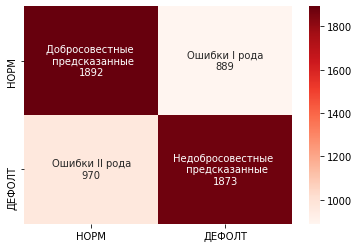

In [169]:
labels = np.asarray(['Добросовестные \n предсказанные'+'\n'+str(tn),
                     'Ошибки I рода'+'\n'+str(fp),
                     'Ошибки II рода'+'\n'+str(fn),  
                     'Недобросовестные \n предсказанные'+'\n'+str(tp)]).reshape(2,2)
categories = ['НОРМ', 'ДЕФОЛТ']
sns.heatmap(confusion_matrix(y_rand_valid, Y_v_predict), annot=labels, fmt='', cmap='Reds', yticklabels= categories, xticklabels= categories)

**С таким количество ошибок второго рода результат неудовлетворительный**

**AUC всё-таки слегка улучшился**

In [170]:
#Странно, почему такой результат? Как THRESHOLD связан с точностью?

Y_v_predict = lr_model.predict(X_rand_valid)          # Непосредсвенно классификация на валидационном сете
Y_v_pred_prob = lr_model.predict_proba(X_rand_valid)  # Предсказанные вероятности для валидационного сета

predictions=pd.Series(Y_v_pred_prob[:,1])
fpr, tpr, thresholds = roc_curve(y_rand_valid, predictions) # Получим список Decreasing thresholds on the decision function used to compute fpr and tpr

accuracy_ls = []
for thres in thresholds:                              #Посчитаем точность предсказания дефолта для каждого уровня Threshold
    y_pred = np.where(predictions>thres,1,0)
    accuracy_ls.append(accuracy_score(y_rand_valid, y_pred, normalize=True)) # normalize=True fraction of correctly classified samples
    
accuracy_ls = pd.concat([pd.Series(thresholds), pd.Series(accuracy_ls)],
                        axis=1)
accuracy_ls.columns = ['thresholds', 'accuracy']
accuracy_ls.sort_values(by='accuracy', ascending=False, inplace=True)
display(accuracy_ls.head(3))
accuracy_ls[accuracy_ls['accuracy']==accuracy_ls['accuracy'].max()]['thresholds'].min()

,thresholds,accuracy
1253,0.478,0.671
1252,0.478,0.671
1254,0.478,0.671


0.4779955042402621

В этой модели используется горазно низкий threshold для достижения максимально возможной точности

(0.0, 1.0)

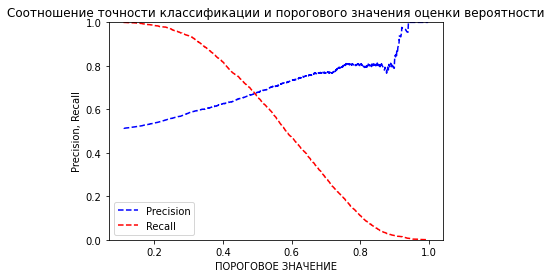

In [171]:
# Precision / Recall Curve
precision, recall, thresholds = precision_recall_curve(y_rand_valid, Y_v_pred_prob[:,1]) 
  
pr_auc = auc(recall, precision)

plt.title("Соотношение точности классификации и порогового значения оценки вероятности")
plt.plot(thresholds, precision[: -1], "b--", label="Precision") # Вероятность, что 1 - вторая колонка предсказанных Y
plt.plot(thresholds, recall[: -1], "r--", label="Recall")
plt.ylabel("Precision, Recall")
plt.xlabel("ПОРОГОВОЕ ЗНАЧЕНИЕ")
plt.legend(loc="lower left")
plt.ylim([0,1])

**Модель конкретно съехала по сравнению с несбалансированной, хотя ROC AUC улучшился

# **ВЫВОДЫ**

Мой вывод из всего этого, что в зависимости от задачи надо выбирать метрики, и прежде чем бороться с несбалансированностью, тоже надо проанализировать задачу.

В данном кейсе несбалансированность вызвана  не качеством выборки, а тем, что в жизни не-дефолтные ситуации гораздо чаше встречаются и набор признаков, который может соответствовать не-дефолтному статусу заёмщика граздо более разнообразен, чем набор признаков, соттветствующий дефолтному. 
Поэтому, когда мы пытались балансировать количество наблюдений посредством уравнивания количесва наблюдений для каждого класса, мы лишали модель информации о некоторых вариантах наборов признаков, описывающих не-дефолтное состояние, и поэтому она начинала хуже предсказывать, и повышалось количество ошибок второго рода.

В данном кейсе главными метриками, на которые надо обращать внимание по моему мнению, являются False Positives и False Negatives. 
Синтетические метрики, такие как F1 и ROC AUC, оказались не очень информативны, так, в модели, которая показывала больше ошибок второго рода, эти метрики были лучше.

Разные модели предлагают разное соотношение ошибок 1 и 2 рода, мне представляется, что модель должна выбираться с целью минимизации убытков, в зависимости от величины средней упущенной выгоды по процентам и средней величины запрашиваемых кредитов?


# Submission


In [ ]:
# ПОДГОТОВИМ SUBMISSION

Y_test_pred_prob = lr_model.predict_proba(X_test)  # Предсказываем вероятности для тестового сета

# Добудем client_ID
client_id=df_test['client_id'].astype('int32').values
sumbission_kaggle = np.c_[client_id, Y_test_pred_prob[:,1]]

print(sumbission_kaggle)


[[74835.             0.04111532]
 [17527.             0.29448895]
 [75683.             0.07151913]
 ...
 [81852.             0.32695055]
 [ 1971.             0.17024978]
 [69044.             0.25625763]]


In [ ]:
from numpy import asarray
from numpy import savetxt

np.savetxt(fname="submission_72.csv", delimiter=",", X=sumbission_kaggle)

In [ ]:
url3='/content/drive/MyDrive/Colab Notebooks/data/submission7347.csv'

In [ ]:
sub_7347 = pd.read_csv(url3, encoding = 'ISO-8859-1', low_memory = False, header=None) 

In [ ]:
sub_7347.to_csv("submission7347.csv",header=['client_id','default'],index=False)